# Machine learning avec les modules Python tensorflow2/keras 

Les concepts de base du *Machine Learning* (ML) peuvent être consultés si besoin dans le notebook du TP1 :  `TP1_MNIST_dense.ipynb`.

## Entraînement / exploitation d'un réseau de neurones convolutionnel pour la reconnaissance de chiffres manuscrits

L'objectif du TP2 est de comprendre le fonctionnement d'un réseau de neurones convolutionnel et de mettre en oeuvre sa construction à l'aide du module **keras**, utilisé comme interface *high level* du module **tensorflow**. <br />

Le séquencement de ce TP reste le même que celui du TP1 :
- Rappels sur le fonctionnement des réseaux convolutionels
- Chargement des images depuis la banque MNIST.<br>
Dans ce TP les images ne sont pas applaties en vecteurs car un réseau convolutionnel accepte des tableaux multidimensionnels en entrée.
- Construction du modèle avec *keras*.
- *one-hot encoding* des labels des images pour les rendre compatibles avec les sorties du réseau de neurones.
- Entraînement & analyse des résultats.

# A/ Les Réseaux de Neurones Convolutionnels (RNC)

## Principes génraux

Les Réseaux de Neurones Convolutionnels (RNC, en anglais *CNN* :*Convolutionnal Neural Networl*) proposent des structures particulièrement efficaces pour l'analyse du contenu des images. Pour cela les RNC mettent en oeuvre des traitements et une architecture et bien spécifiques :
- l'extraction des caractéristiques des images (*features*) à l'aide de filtres convolutifs,
- la réduction de la quantité d'information générée par la convolution avec des filtres de *pooling*,
- une architecture qui empile des structures "convolution > activation > pooling..." chargées d'extraire les caractéristiques de l'image (*features*) qui sont au final applaties et envoyées en entrée d'un réseau dense chargé de l'étape de classification.

Dans la suite du TP, nous construirons un RNC inspiré du réseau `LeNet5`, un des premiers RNC proposé par Yann LeCun *et al.* dans les années 90 pour la reconnaisannce des images MNIST :

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/LeNet5.png" ><br>
    [Lecun, Y.; Bottou, L.; Bengio, Y.; Haffner, P. (1998). "Gradient-based learning applied to document recognition". Proceedings of the IEEE. 86 (11): 2278–2324. doi:10.1109/5.726791.]
</p>

### Extraction des caractéristiques d'une image avec un filtre de convolution

La convolution d'une image par un filtre (aussi appelé noyau, *kernel*) revient à déplacer une 'petite' fenêtre 2D ( 3x3, 5x5 ....) sur l'image et à calculer à chaque fois le produit tensoriel contracté entre les élements du filtre et les pixels de l'image délimités par le filtre (somme des produits terme à terme).<br>

L'animation ci-dessous illustre la convolution d'une image 5x5 par un filtre 3x3 sans *padding* sur les bords : on obtient une nouvelle image plus petite de 3x3 pixels<br>
<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/filter_3x3.png" width="80" style="display:inline-block;">
    <img src="img/Convolution_schematic.gif" width="300" style="display:inline-block;"><br>
    [crédit image : <a href="http://deeplearning.stanford.edu/tutorial">Stanford deep learning tutorial</A>]
</p>

Pour conserver la taille de l'image traitée, on peut faire appel à du *padding* pour créer de nouvelles données sur les bords de l'image (par dupplication des données sur les bords par exemple) : 

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/padding.gif" width="350"><br>
    [crédit image : <a href="https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2"> Arden Dertat</a> ]
</p>

Le but de la convolution est d'extraire des caractéristiques particulières présentes dans l'image source : on parle de "carte des caratéristiques" (*feature map*) pour désigner l'image produite par l'opération de convolution. L'état de l'art conduit à utiliser plusieurs filtres convolutifs pour extraire des caractéristiques différentes : on peut avoir jusqu'à plusieurs dizaines de filtres convolutifs dans un même couche du réseau qui génèrent autant de *feature map*.

#### Exemples d'extraction de caractéristiques avec des filtres convolutifs connus (filtre de [Prewitt](https://fr.wikipedia.org/wiki/Filtre_de_Prewitt)):

À titre d'exemple, la figure ci-dessous montre les *features maps* obtenues en convoluant une image MNIST (un chiffre 7) avec 4 filtres 3x3 connus en traitement d'image (filtres de Prewitt pour l'extraction de contours):

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/7_mnist_4_filtres.png" width="500"><br>
    [crédit image : JLC]
</p>

On voit que ces filtres agissent comme des filtres de détection de contour : dans les images de sortie, les pixels les plus blancs constituent ce que les filtres ont détecté :
- les filtre (a) et (c) détectent des contours horizontaux inférieurs et supérieurs,
- les filtre (b) et (d) détectent des contours verticaux droite et gauche.

Ces exemples très simples permettent de comprendre comment fonctionne l'extraction des *features* d'une image par filtrage convolutif.

###### Cas général : images RGB traitée par plusieurs filtres de convolution

Dans le cas général où les images correpondent à des tableaux 3D (les 3 couleurs R(ed), G(reeen) &  B(lue)), le filtre de convolution est lui aussi un tableau 3D. L'opération reste identique au cas 1D : pour une position du filtre 3D sur l'image, le produit tensoriel contracté du filtre avec le sous-tableau 3D correspondant dans l'image fournit un nombre scalaire, et le balayage du procédé sur toute l'image donne la matrice des caractéristiques (*feature map*) de l'image. 

Par exemple si l'on utilise 10 filtres de convolution 5x5 (10 tableaux de dimensions (5,5,3)) pour filtrer une image RGB de 32x32 pixels (tableau de dimensions (32,32,3), on obtient une *feature maps*  de dimensions (32,32,10), soit 10240 termes alors que l'image source n'en a que 1024 !

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/conv_3D_10.png" width="350"><br>
    [crédit image : <a href="https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2"> Arden Dertat</a> ]
</p>

$\leadsto$ Pour réduire la quantité d'information générée par les filtres de convolution sans perdre trop d'information, la convolution est toujours suivie d'une opération de *pooling*.

#### Du filtre convolutif à la couche de neurones convolutifs

L'intégration du filtrage convolutif dans la structure du réseau de neurones donne l'organisation des calculs  suivante :

- Chaque filtre convolutif posssède les mêmes coefficients pour les 3 couleurs : pour le réseau LeNet5 par exemple, chacun des 6 filtres 5x5x3 de la première possède seulement 25 coefficients, identiques pour les plans R, G & B.

- Chaque unité (neurone) d'une *feature map* de la couche C1 reçoit 75 valeurs de pixels (25 pixels rouges $R_i$, 25 pixels vert $G_i$ et 25 pixels bleus $B_i$) délimités par la position du filtre dans l'image.

- Le neurone $k$ d'une *feature map* calcule une sortie $y_k = F_a(\sum_{i=1}^{25}{\omega_i(R_i + G_i + B_i) - b_k})$, où $b_k$ est le biais du neurone $k$ et $F_a$ la fonction d'activation (très souvent `relu`).

- on a donc  6 x (25 + 1) paramètres, soit 156 paramètres inconnues, pour la couche C1 qui seront déterminé par entraînement du réseau.

Le même schéma est utilisé dans toutes les couches convoltionnelles.


### Le *pooling*

Le *pooling* vise à réduire quantité de données à traiter. Comme pour l'opération de convolution, on déplace un filtre sur les éléments du tableau *feature map*  et à chaque position du filtre sur le tableau, on calcule un nombre représentant tous les éléments sélectionnés dans le filtre (par exemple la valeur maximale, ou la moyenne....). Mais contrairement à la convolution, on déplace le filtre sans recouvrement.<br>
Dans l'exemple simplifié ci-dessous, le filtre *max spool* transforme la matrice 8x8 en une matrice 4x4 qui contient "à peu près" la même information :
<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/max_pool_2x2.png" width="350"><br>
    [crédit image : JLC</a> ]
</p>

# C/ Travail à faire

## Environnement Python de travail

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
L'état de l'art actuel des projets de machine learning sous Python préconise l'utilisation d'un <span style="font-weight:bold;">Environnement Virtuel Python</span> (EVP) qui permet de maîtriser pour chaque projet les versions des modules Python "sensibles" (comme tensorflow par exemple).

Dans le cas d'un démarrage de l'ordinateur avec une clef USB Ubuntu, on peut considérer que la clef fournit un environnement Python dédié, à condition de ne pas faire de mises à jour des paquets Python avec <span style="font-style:italic">pip install...</span>
    
Dans le cas contraire, la <A href="https://learn.ros4.pro/fr/faq/Python/">FAQ Python</A> explique comment créer et utiliser un EVP pour utiliser **numpy** et **tensorflow2** avec la bibliothèque optimisée <A href="https://software.intel.com/content/www/us/en/develop/tools/oneapi/components/onemkl.html">MKL</A>.
</span>
</div>

### Modules Python tensorflow/keras

Le module **keras** qui permet une manipulation de haut niveau des objets **tensorflow** est intégré dans le module **tensorflow** (tf) depuis la version 2. <br>
La documentation du module **tf.keras** à consulter pour ce TP est ici : https://www.tensorflow.org/api_docs/python/tf/keras. 

Versions des modules Python validées pour ce TP sous Ubuntu 20 / Python3.8.5 :
- tensorflow 2.4.0 incluant tensorflow.keras 2.4.0
- OpenCV 4.2.0

In [1]:
import tensorflow as tf
from tensorflow import keras
import sys, cv2
print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"OpenCV    : {cv2.__version__}")

Python    : 3.8.5
tensorflow: 2.4.0 incluant keras 2.4.0
OpenCV    : 4.4.0


#### Incrustation des tracés matplotlib dans le cahier IPython et import de modules utiles :

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#### Affectation des graines (*seed*) des générateurs pseudo-aléatoires :

Le TP1 donne plus de détails sur la reproductibilité des générateurs pseudo-aléatoires utilisés.

In [3]:
SEED = 123
np.random.seed(SEED)      
tf.random.set_seed(1234)

## 1 - Récupération et mise en forme des données MNIST

Plus de détails sur les images MNIST sont donnés dans le notebook `TP1_MNIST_dense.ipynb`.

Consulter la documentation de la fonction `load_data` sur la page [tf.keras.datasets.mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data) puis compléter la cellule ci-dessous pour charger les données du MNIST en nommant les données renvoyées :<br>
- `im_train`, `im_test` pour les images d'entraînement et de test,
- `lab_train`, `lab_test` pour les labels des données d'entraînement et de test.

In [4]:
(im_train, lab_train), (im_test, lab_test) = tf.keras.datasets.mnist.load_data()

La cellule ci-dessous affiche les attributs `shape` et `dtype` des tableaux numpy obtenus : les valeurs son-elles cohérentes ?

In [5]:
print("im_train -> shape:", im_train.shape, ", dtype:", im_train.dtype,)
print("im_test  -> shape:", im_test.shape,  ", dtype:", im_test.dtype,)
print("lab_train-> shape:", lab_train.shape,  ", dtype:", lab_train.dtype)
print("lab_test -> shape:", lab_test.shape,  ", dtype:", lab_test.dtype)

im_train -> shape: (60000, 28, 28) , dtype: uint8
im_test  -> shape: (10000, 28, 28) , dtype: uint8
lab_train-> shape: (60000,) , dtype: uint8
lab_test -> shape: (10000,) , dtype: uint8


## Mise en forme des données d'entrée

Les couches convolutionnelles du module keras attendent des tableaux multidimentionnels de la forme `(batch_size, width, height, dpth)` :
- `batch_size` : nombre d'image en entrée,
- `width` et `height` : largeur et hauteur des images (en pixels),
- `depth` : profondeur des tableaux (`3` pour une image RGB, `1` pour une image en ton de gris).

La forme des images MNIST est :

In [6]:
im_train.shape, im_test.shape

((60000, 28, 28), (10000, 28, 28))

Il faut donc rajouter une dimension (égale à `1`) après la troisième dimension `28`, par exemple avec la méthode `reshape` des tableaux `ndarray` de numpy.

(Compléter la cellule suivante pour définir `x_train` et `x_test` obtenus en ajoutant une quatrième dimension égale à 1) aux tableaux `im_train` et `im_test` et en normalisant les valeurs :

In [7]:
# avec  la méthode reshape des tableaux ndarray de numpy :
x_train = im_train.reshape(im_train.shape + (1,))
x_test  = im_test.reshape(im_test.shape + (1,))
x_train, x_test = x_train/ 255.,x_test/255

Vérification :

In [8]:
im_train.shape, x_train.shape, im_test.shape, x_test.shape

((60000, 28, 28), (60000, 28, 28, 1), (10000, 28, 28), (10000, 28, 28, 1))

### Mise au format *one-hot* des labels MNIST

Il faut mettre les labels MNIST au format *one-hot* qui permet de calculer l'erreur entre un label et la sortie de la couche de classification du réseau (voir le TP1 pour les détails sur le format *one-hot*).<br>
Consulter la page [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) sur la fonction `to_categorical` et en déduire comment transformer les tableaux `lab_train` et `lab_test` en tableaux `y_train` et `y_test` contenant des vecteurs encodés *hot-one* :


In [9]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' des labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

## 3 - Construction du réseau de neurones

On va maintenant construire dans la cellule ci-dessous le réseau de neurones **convolutionnel** à l'aide du module **keras**.

Comme dans le TP1, on crée un objet instance de la classe `Sequential` (cf [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) que l'on pourra nommer `net_conv`, puis on complète `net_conv` de façon  incrémentale en ajoutant chaque couche avec la méthode `add` :

- La couche d'entrée de type `InputLayer` (cf [tf.keras.layers.InputLayer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer)) sert à spécifier la forme des données d'entrée.<br>
La forme attendue par keras pour des images en entrée est (width,height,depth) : on pourra l'obtenir par exemple avec l'attribut `shape` de n'importe quelle image du jeu `x_train` reformaté.<br><br>

- Les couches convolutionnelles sont de type `Conv2D` (cf [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)) :
    - les 2 premiers arguments (positionnels) sont : 
        - le nombre de filtres de la couche
        - la forme du filtre : on peut spécifier  `N` ou `(N,N)` pour spécifier un filtre N x N
    - les autres arguments (nommés) utilisés sont :
        - `stride` : le pas du déplacement du filtre de convolution, valeur par défaut :  `stride=1` (équivalent à `(1, 1)`))
        - `padding=valid` : pas de padding, ou `padding=same` : sortie de même dimensions que l'entrée (défaut : `valid`)
        - `activation` : choix de la focntion d'activation (`'relu'`, '`tanh'`...)<br><br>
        
- Les couches de *pooling* du réseau LeNet5 historique utilisent un filtre *average pool* qui correspond à la classe `AveragePooling2D`  (cf [tf.keras.layers.AveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D), mais on aura de meilleurs résultats avec un filtrage *max pool* qui retient la valeur max des pixels dans la fenêtre du filtre (voir la page [tf.keras.layers.MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)). Principaux arguments à utiliser avec `MaxPool2D` :
    - `pool_size` :  `N` ou `(N,N)` pour spécifier un filtre N x N (défaut : `(2,2)`)
    - `strides` : int, tuple de 2 int, ou None. Si None (valeur par défaut), prend la même valeur que `pool_size`
    - `padding` : comme pour la classe `Conv2D`<br><br>

- Pour applatir les 16 *feature maps* 5x5 en un vecteur de 16*5*5=635 éléments, on peut utiliser une couche  `Flatten` (cf [tf.keras.layers.Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten))<br><br>

Avec les spécification du réseau Net5 de la figure ci-dessous, on obtient :
- couche d'entrée : `Input(shape=x_train[0].shape)` : on utilise l'attribut `shape` de la 1ère image (28x28 pixels gris) qui vaut (28,28,1).
- couche C1 : `Conv2D(6, 5, padding='same', activation='relu', name='C1')`
- couche S2 : `MaxPool2D(pool_size=2, name='S2')`
- couche C3 : `Conv2D(16, 5, padding='valid', activation='relu', name='C3')`
- couche S4 : `MaxPool2D(pool_size=2, name='S4')`
- couche d'applissement : `Flatten()`
- couche C5 : `Dense(200, activation='relu', name='C5')`
- couche F5 : `Dense(84, activation='relu', name='F6'`
- couche OUTPUT : `Dense(nb_classe, activation='softmax', name='Output')`

Une fois construit, le réseau doit être compilé (au sens de tensorflow) avec la méthode `compile` en utilisant par exemple les :
- `loss='categorical_crossentropy'` : choix de la fonction d'erreur (cf [tf.keras.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy))
- `optimizer='adam'` : choix de l'optimiseur Adam (cf page [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam))
- `metrics=['accuracy']` pour obtenir les données permettant de tracer les courbes de performance.

In [10]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, AveragePooling2D, MaxPool2D, Flatten

nb_classe = 10
tf.random.set_seed(SEED)

net_conv = Sequential(name='lenet')
net_conv.add(Input(shape=x_train[0].shape))
net_conv.add(Conv2D(6, 5, padding='same', activation='relu', name='C1'))
net_conv.add(MaxPool2D(pool_size=2, name='S2'))
net_conv.add(Conv2D(16, 5, padding='valid', activation='relu', name='C3'))
net_conv.add(MaxPool2D(pool_size=2, name='S4'))
net_conv.add(Flatten())
net_conv.add(Dense(200, activation='relu', name='C5'))
net_conv.add(Dense(84, activation='relu', name='F6'))
net_conv.add(Dense(nb_classe, activation='softmax', name='Output'))
net_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Avec la méthode `summary` de l'objet `net_conv`, faire afficher la description du modèle : noter les valeurs des paramètres...

In [11]:
net_conv.summary()

Model: "lenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 28, 28, 6)         156       
_________________________________________________________________
S2 (MaxPooling2D)            (None, 14, 14, 6)         0         
_________________________________________________________________
C3 (Conv2D)                  (None, 10, 10, 16)        2416      
_________________________________________________________________
S4 (MaxPooling2D)            (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
C5 (Dense)                   (None, 200)               80200     
_________________________________________________________________
F6 (Dense)                   (None, 84)                16884 

La fonction `tf.keras.utils.plot_model.plot_model` permet aussi de dessiner la structure du réseau (voir la page [tf.keras.utils.plot_model](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model)).<br>
Faire tracer la structure du modèle en ajoutant l'option `show_shapes=True` à l'appel de `net_conv` :

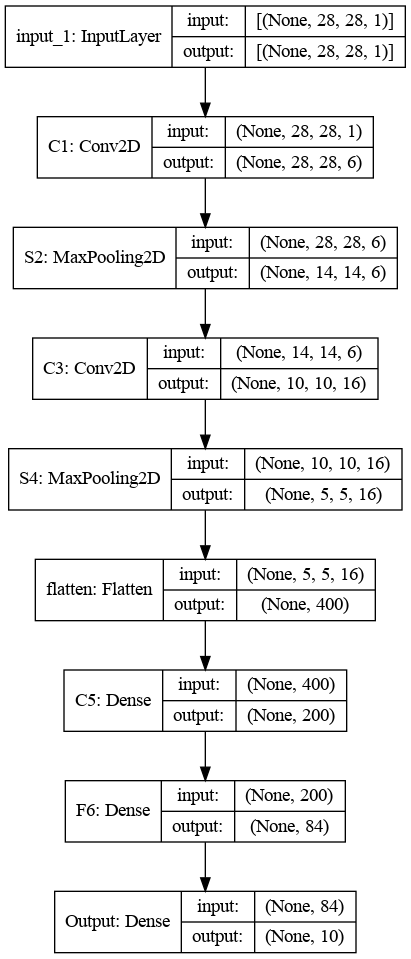

In [12]:
tf.keras.utils.plot_model(net_conv, show_shapes=True)

### Sauvegarde de l'état initial du  réseau

On peut sauvegarder l'état initial des poids du réseau non-entraîné (valeurs aléatoires) avec la méthode `Model.save_weights`. <br>
Ce sera utile plus loin pour remettre le réseau à son état initial avant de relancer d'autres entraînements :

In [13]:
import os

# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("weights"): os.mkdir("weights")

# sauvegarde des poinds du réseau initial:
key = 'net_conv_initial'
net_conv.save_weights('weights/'+key)

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/net_conv_initial.index
weights/net_conv_initial.data-00000-of-00001


Remarque : la méthode `save_weights` utilise la partie `key` du chemin passé en argument pour préfixer les fichiers créés.<br>
Lors de la lecture ultérieure des poids du réseau avec la méthode `load_weights` de la classe `Sequential`, il suffira de donner la même information pour retrouver les bons fichiers.

## 4 - Entraînement du réseau avec test à chaque `epoch`

Consulter au besoin la documentation de la méthode `fit` dans la page [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential). 

Compléter la cellule ci-dessous pour entraîner le réseau en utilisant la méthode `fit` de l'objet `net_conv` avec les arguments :
- `x_train` : les 60000 images 
- `y_train` : les 60000 labels encodés *one-hot*.
- `epochs=10` : faire 10 fois l'entraînement complet.
- `batch_size=128` : découper le jeu des données d'entrée (les 60000 images) en "lots" (*batch*) de taille `batch_size`.<br>
La mise à jour des poids du réseau est faite au bout de `batch_size` échantillons d'entrée. La valeur de `batch_size` (par défaut est 32) est un paramètre qui influe beaucoup sur la qualité de l'apprentissage : on peut essayer d'autres valeurs (64, 128 ...) et observer comment évoluent les performances d'entraînement).



Pour avoir un indicateur réaliste de la qualité du réseau entraîné on teste à chaque `epoch` la précison du réseau entraîné en utilisant les données de test : il faut passer l'agument `validation_data` à la méthode `fit`, en lui affectant le tuple des données de test `(x_test, y_test)`

In [14]:
# au cas on on exécute plusieurs fois cette cellule, il faut ré-initialiser 
# les poids du réseau à leur valeur initiale si on veut comparer les entraînements...
key = 'net_conv_initial'
net_conv.load_weights('weights/'+key)  
tf.random.set_seed(SEED)

hist = net_conv.fit(x_train, y_train, 
                    validation_data=(x_test, y_test),
                    batch_size=128,
                    epochs=10)

Epoch 1/10
469/469 [==============================] - 22s 45ms/step - loss: 0.5721 - accuracy: 0.8345 - val_loss: 0.0728 - val_accuracy: 0.9767
Epoch 2/10
469/469 [==============================] - 18s 38ms/step - loss: 0.0809 - accuracy: 0.9752 - val_loss: 0.0541 - val_accuracy: 0.9821
Epoch 3/10
469/469 [==============================] - 18s 39ms/step - loss: 0.0515 - accuracy: 0.9845 - val_loss: 0.0463 - val_accuracy: 0.9861
Epoch 4/10
469/469 [==============================] - 20s 42ms/step - loss: 0.0433 - accuracy: 0.9860 - val_loss: 0.0472 - val_accuracy: 0.9853
Epoch 5/10
469/469 [==============================] - 20s 43ms/step - loss: 0.0337 - accuracy: 0.9893 - val_loss: 0.0367 - val_accuracy: 0.9882
Epoch 6/10
469/469 [==============================] - 20s 42ms/step - loss: 0.0287 - accuracy: 0.9914 - val_loss: 0.0339 - val_accuracy: 0.9878
Epoch 7/10
469/469 [==============================] - 19s 40ms/step - loss: 0.0231 - accuracy: 0.9929 - val_loss: 0.0373 - val_accuracy:

L'objet `hist` retourné par la méthode `fit` possède un attribut `history` de type dictionnaire dont les clefs `'loss'`, `'accuracy'` contiennent l'évaluation de la fonction de cout et de la précision du réseau à la fin de chaque (*epoch*) avec les données d'entraînement. Les clefs `'val_loss'` et `'val_accuracy'` sont associées aux données de test.

In [15]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [16]:
hist.history['loss'], hist.history['accuracy'], hist.history['val_loss'], hist.history['val_accuracy'], 

([0.260856568813324,
  0.07382764667272568,
  0.05387888476252556,
  0.04239213839173317,
  0.034550104290246964,
  0.028846120461821556,
  0.02274167910218239,
  0.020247934386134148,
  0.017623214051127434,
  0.014930705539882183],
 [0.9258833527565002,
  0.9769166707992554,
  0.9832166433334351,
  0.9865666627883911,
  0.9889333248138428,
  0.9912999868392944,
  0.9927833080291748,
  0.9933833479881287,
  0.9939833283424377,
  0.9946833252906799],
 [0.07282174378633499,
  0.05405360087752342,
  0.046311892569065094,
  0.04719240590929985,
  0.03665591776371002,
  0.033882662653923035,
  0.03725428879261017,
  0.03399189934134483,
  0.03624262660741806,
  0.0361853763461113],
 [0.9767000079154968,
  0.9821000099182129,
  0.9861000180244446,
  0.9853000044822693,
  0.9882000088691711,
  0.9878000020980835,
  0.9883000254631042,
  0.9897000193595886,
  0.9886000156402588,
  0.9891999959945679])

#### Tracé des courbes `accuracy` et `loss`  de l'entraînement et des test :

La fonction `plot_loss_accuracy` du module `utils.tools` (présent dans le répertoire du notebook) permet de tracer les courbes de précision et de perte en utilisant les données stockées dans l'objet `hist`. Faire tracer ces courbes :

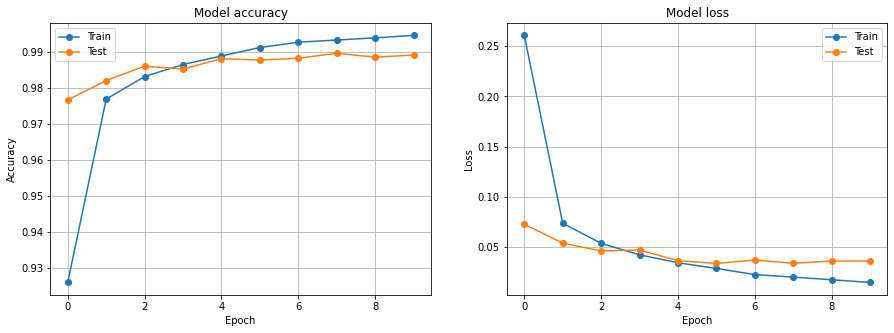

In [17]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

### Arrêter automatiquement l'entraînement avant *over-fit*

Keras propose des outils pour arrêter automatiquement l'apprentissage en surveillant par exemple la croissance de la précision d'une `epoch` à l'autre. On peut ainsi définir une liste de fonctions *callback* que l'on peut passer en argument à la focntion `fit` avec l'agument nommé  `callbacks` :

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks_list = [
    EarlyStopping(monitor='val_accuracy',  # la grandeur à surveiller
                  patience=2,              # on accepte que 'val_accuracy' puisse diminuer 2 fois de suite
                  verbose=1)
]

# recharger l'état initial du réseau:
key = 'net_conv_initial'
net_conv.load_weights('weights/'+key)  
tf.random.set_seed(SEED)

hist = net_conv.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=15, 
                    batch_size=128, 
                    callbacks = callbacks_list)

Epoch 1/15
469/469 [==============================] - 19s 40ms/step - loss: 0.2272 - accuracy: 0.9298 - val_loss: 0.0522 - val_accuracy: 0.9828
Epoch 2/15
469/469 [==============================] - 18s 39ms/step - loss: 0.0550 - accuracy: 0.9825 - val_loss: 0.0422 - val_accuracy: 0.9856
Epoch 3/15
469/469 [==============================] - 18s 39ms/step - loss: 0.0400 - accuracy: 0.9873 - val_loss: 0.0377 - val_accuracy: 0.9874
Epoch 4/15
469/469 [==============================] - 19s 41ms/step - loss: 0.0303 - accuracy: 0.9901 - val_loss: 0.0404 - val_accuracy: 0.9879
Epoch 5/15
469/469 [==============================] - 26s 56ms/step - loss: 0.0253 - accuracy: 0.9921 - val_loss: 0.0372 - val_accuracy: 0.9891
Epoch 6/15
469/469 [==============================] - 19s 40ms/step - loss: 0.0215 - accuracy: 0.9932 - val_loss: 0.0312 - val_accuracy: 0.9895
Epoch 7/15
469/469 [==============================] - 19s 40ms/step - loss: 0.0173 - accuracy: 0.9944 - val_loss: 0.0394 - val_accuracy:

Tracer les courbes `loss` et `accuracy` :

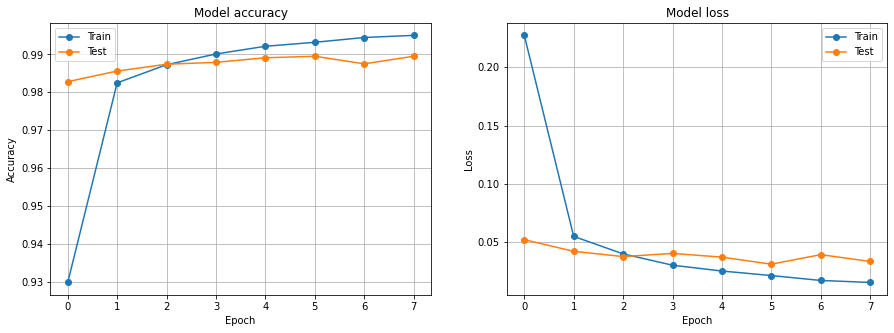

In [19]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

Le réseau convolutionnel tend vers une meilleure précision voisine de 99%.

### Sauvegarder les poids du  réseau entraîné

La méthode `save_weights` de la classe `Sequential`permet d'enregistrer les **poids** du réseau entraïné dans un fichier :

In [20]:
import os
# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("weights"): os.mkdir("weights")

# sauvegarde des poids du réseau entrainé:
key = 'net_conv_trained'
net_conv.save_weights('weights/'+key)

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/net_conv_trained.data-00000-of-00001
weights/net_conv_trained.index


### Sauvegarder la structure du réseau et ses poids

La méthode `save` de la classe `Sequential` permet d'enregistrer **toute la structure et les poids** du réseau entraïné dans un fichier.<br />
Ceci permet de recréer plus tard *from scratch* le réseau entrainé pour passer en phase exploitation du réseau par exemple, en utilisant la fonction`tf.keras.models.load_model` :

In [21]:
import os
# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("models"): os.mkdir("models")

# sauvegarder structure réseau + poids :
key = 'net_conv'
net_conv.save('models/'+key) 

# afficher les fichiers créés:
files=[os.path.join("models",f) for f in os.listdir("models") if f.startswith(key)]
for f in files: print(f)

INFO:tensorflow:Assets written to: models/net_conv/assets
models/net_conv


## 6/ Exploitation du réseau avec le jeu de test

La méthode `predict` de l'objet `net_conv` permet de calculer la prédiction du réseau pour une ou plusieurs entrées (voir la méthode `predict`dans la page [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)).

La cellule ci-dessous montre la mise en oeuvre de la méthode `predict`, et comment exploiter la représentation  *one-hot* renvoyée par `fit` en utilisant la méthode `argmax` des tableaux de numpy :

sortie du réseau pour l'image de rang 100 :
[1.2168309e-05 7.5744380e-09 2.8134386e-09 3.1641376e-10 8.7270628e-08
 7.8123503e-07 9.9998426e-01 2.7852018e-11 2.6475104e-06 1.9740405e-10]

sortie réseau arrondie à 2 chiffre : [0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00]
rep[0].argmax() donne : 6

La bonne réponse est 6 soit en 'one-hot' : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


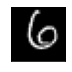

In [22]:
from utils.tools import plot_images

i = 100   # numéro image de test
rep = net_conv.predict(x_test[i:i+1]) # Attention: x doit être un tableau de matrices...
                                   # => x[i] ne convient pas !

print(f"sortie du réseau pour l'image de rang {i} :\n{rep[0]}")

# limiter l'affichage des composantes des tableaux numpy à 1 chiffre :    
with np.printoptions(formatter={'float':'{:.2f}'.format}):    
    print(f"\nsortie réseau arrondie à 2 chiffre : {rep[0]}")
    
print(f"rep[0].argmax() donne : {rep[0].argmax()}")

print(f"\nLa bonne réponse est {lab_test[i]} soit en 'one-hot' : {y_test[i]}")

plot_images(im_test,i,1,1)

#### Utilité de la méthode numpy `ndarray.argmax` pour décoder le tableau de vecteurs *one-hot* renvoyé par la méthode `predict`

Quand on calcule la prédiction du réseau `net_conv` avec les données de test par exemple, on obtient un résultat qui est un tableau de vecteurs codés *one-hot*, comme le détaille la cellue suivante :

In [23]:
results = net_conv.predict(x_test)

print("forme du tableau 'results':", results.shape)
print("allure des vecteurs du tableau 'result', par exemple :")
with np.printoptions(formatter={'float':'{:.4f}'.format}): 
    print("results[0]  :", results[0])
    print("results[-1] :", results[-1])

forme du tableau 'results': (10000, 10)
allure des vecteurs du tableau 'result', par exemple :
results[0]  : [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000]
results[-1] : [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000]


En écrivant `results.argmax(axe=-1)`, on obtient le tableau des `argmax` de chaque vecteur -> c'est directement le tableau des chiffres reconnus par le réseau :

In [24]:
chiffres_reconnus = results.argmax(axis=-1)

print("chiffres_reconnus -> shape:", chiffres_reconnus.shape, ", dtype:", chiffres_reconnus.dtype)
print(f"contenu de chiffres_reconnus : {chiffres_reconnus}")

chiffres_reconnus -> shape: (10000,) , dtype: int64
contenu de chiffres_reconnus : [7 2 1 ... 4 5 6]


En déduire le taux de réussite du réseau entrainé en calculant la prédiction du réseau sur les données de test `x_test` et en les comparant aux labels `lab_test` :

In [25]:
results = net_conv.predict(x_test)
chiffres_reconnus = results.argmax(axis=-1)

success = 0
for i, res in enumerate(chiffres_reconnus):
    success += (res == lab_test[i])
print(f"taux de réussite : {success/len(x_test)*100:.2f} %")

taux de réussite : 98.95 %


###  Afficher la matrice de confusion

La cellule suivante définie la fonction `show_cm_mnist` qui affiche la **matrice de confusion**.

La matrice de confusion permet de visualiser :
- sur la diagonale : les bonnes réponses du réseau, avec dans chaque case le nombre de bonnes réponses
- hors diagonale : les erreurs du réseau, avec dans chaque case la fréquence d'apparition de l'erreur.

In [26]:
import pandas as pd
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

def show_cm_mnist(target, results, classes):
    # target : the actual labels
    # results : the labels computed by the trained network (one-hot format)
    # classes : list of possible label values
    predicted = np.argmax(results, axis=-1) # tableau d'entiers entre 0 et 9 
    cm = confusion_matrix(target, predicted)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(11,9))
    heatmap(df_cm, annot=True);

Faire afficher la matrice de confusion en lui passant les labels attendus `lab_test` et les labels calculés par le model :

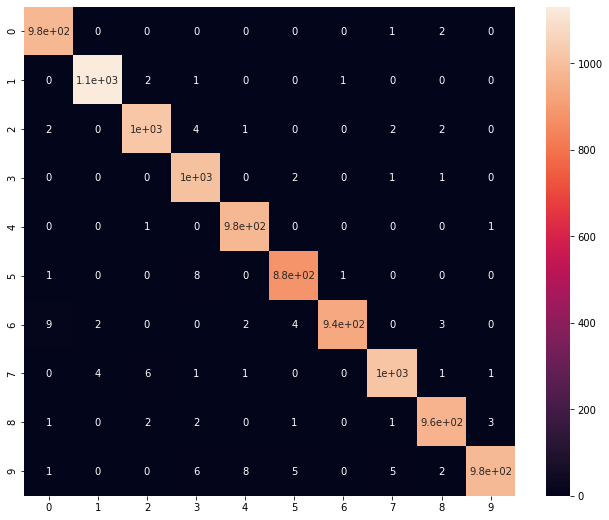

In [27]:
show_cm_mnist(lab_test, net_conv(x_test), range(nb_classe))

Effectivement, il y a assez peu d'erreurs hors diagonale.

# D/ Bonus

## Faire reconnaître des images originales à un réseau entraîné avec les images MNIST

Plusieurs possibilités :
- utiliser des images crées pour l'occasion... 
- utiliser les images toutes prêtes du répertoire `chiffres`.

Si tu crées tes propres images de chiffres écrits à la main, il faut :
- les mettre au format MNIST (20x28 pixels en ton de gris, chiffre centré dans l'image) 
- les placer dans un répertoire spécifique ,
- affecter ce nom de ce répertoire à `images_dir` dans la cellule ci-dessous :

In [28]:
import os

# changer le nom du répertoire au besoin :
images_dir = "chiffres"

images = [os.path.join(images_dir,f) for f in os.listdir(images_dir) if f.endswith(".png")]
images.sort()

print(f"Images du dossier <{images_dir}> à reconnaître :")
for im in images: print(im)

Images du dossier <chiffres> à reconnaître :
chiffres/0.png
chiffres/1.png
chiffres/2.png
chiffres/3.png
chiffres/4.png
chiffres/5.png
chiffres/6.png
chiffres/7.png
chiffres/8.png
chiffres/9.png


### Lecture des fichiers image avec openCV

Les images doivent être convertie en image en ton de gris de 28 x 28 pixels pour pouvoir être traitées par le réseau entraîné sur les images MNIST.

Plusieurs fonctions du module OpenCV pourront être utilisées :
- `cv2.imread(file_name)` : pour lire un fichier image aux formats standards (PNG, JPG,...)
- `cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)` : pour convertir le tableau `img` renvoyé par `cv2.imread` en tons de gris
- `cv2.resize` : pour retailler l'image.

La cellule ci-dessous montre un exemple de lecture et traitement avec OpenCV des images du dossier `chiffres` qui sont déjà au format 28 x 28 pixe :

In [29]:
import cv2
my_images = []
for image_path in images:
    img = cv2.imread(image_path)                    # lecture fichier image
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # conversion en tons de gris
    my_images.append(img_gray)

Visualisation des images lues :

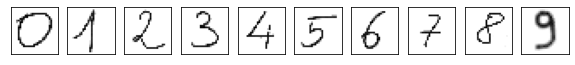

In [30]:
plot_images(my_images, 0, 1, 10)

Inversion des images pour avoir des chiffres doivent être en blanc sur fond noir :

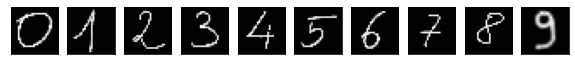

In [31]:
my_images = [255 - im for im in my_images]
plot_images(my_images, 0, 1, 10)

On peut maintenant :
- transformer des matrices 28x28 en vecteurs de float normalisés,
- calculer le prédiction du réseau entaîné de votre choix (`model` ou autre...) avec les images perso en entrée,
- faire afficher la précision obtenue et la matric de confusion.

In [32]:
my_images = np.array(my_images)

nb_images = my_images.shape[0]
nb_pixel  = my_images[0].size

# resize des matrices au format attendu par keras :
my_x = my_images.reshape(my_images.shape + (1,))/255.

[0 1 2 3 4 5 6 3 8 9]


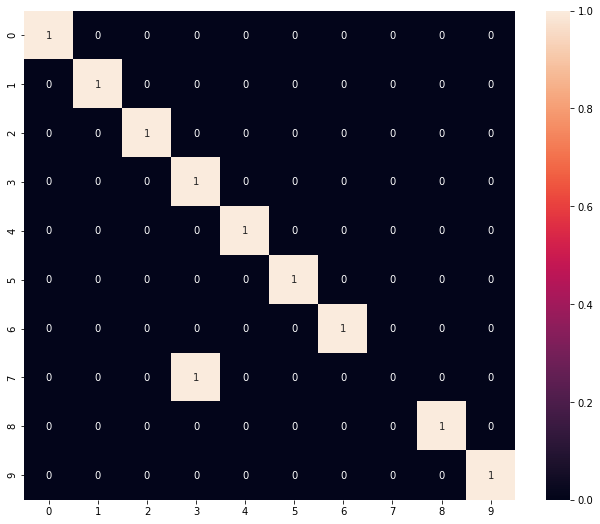

In [33]:
my_results = net_conv.predict(my_x)
print(my_results.argmax(axis=-1))
target    = np.array([0,1,2,3,4,5,6,7,8,9])
show_cm_mnist(target, my_results, range(10))

Que suggèrent les  résultats ?

# Autres ressources intéressantes... des vidéos :

In [34]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [35]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [36]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [37]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>